In [1]:
import os
import sys
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import patterns.python.subgraph_centrality as sgc
from os import listdir
from os.path import isfile, join


In [3]:
def get_metrics(image_array):
    
    feature_vec, sel_pixels = sgc.subgraph_centrality(image_array)
    # get the images showing the selected sub-regions
    feature_vec_metrics = sgc.feature_vector_metrics(feature_vec)
    
    return feature_vec_metrics


In [4]:
list_gaps = [f for f in listdir("../gee/GAPS/") if isfile(join("../gee/GAPS/", f))]

metrics = []
for image in list_gaps: 
    image_array = sgc.read_image_file("../gee/GAPS/"+image)
    m = get_metrics(image_array)
    m['cat'] = 1
    metrics.append(m)
    
gaps = pd.DataFrame.from_dict(metrics)

In [5]:
list_spots = [f for f in listdir("../gee/SPOTS/") if isfile(join("../gee/SPOTS/", f))]

metrics = []
for image in list_spots: 
    image_array = sgc.read_image_file("../gee/SPOTS/"+image)
    m = get_metrics(image_array)
    m['cat'] = 2
    metrics.append(m)
    
spots = pd.DataFrame.from_dict(metrics)

In [6]:
list_lab = [f for f in listdir("../gee/LABYRINTHS/") if isfile(join("../gee/LABYRINTHS/", f))]

metrics = []
for image in list_lab: 
    image_array = sgc.read_image_file("../gee/LABYRINTHS/"+image)
    m = get_metrics(image_array)
    m['cat'] = 3
    metrics.append(m)
    
lab = pd.DataFrame.from_dict(metrics)

In [7]:

total = pd.concat([gaps,spots,lab])

/anaconda3/envs/patterns/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/patterns/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


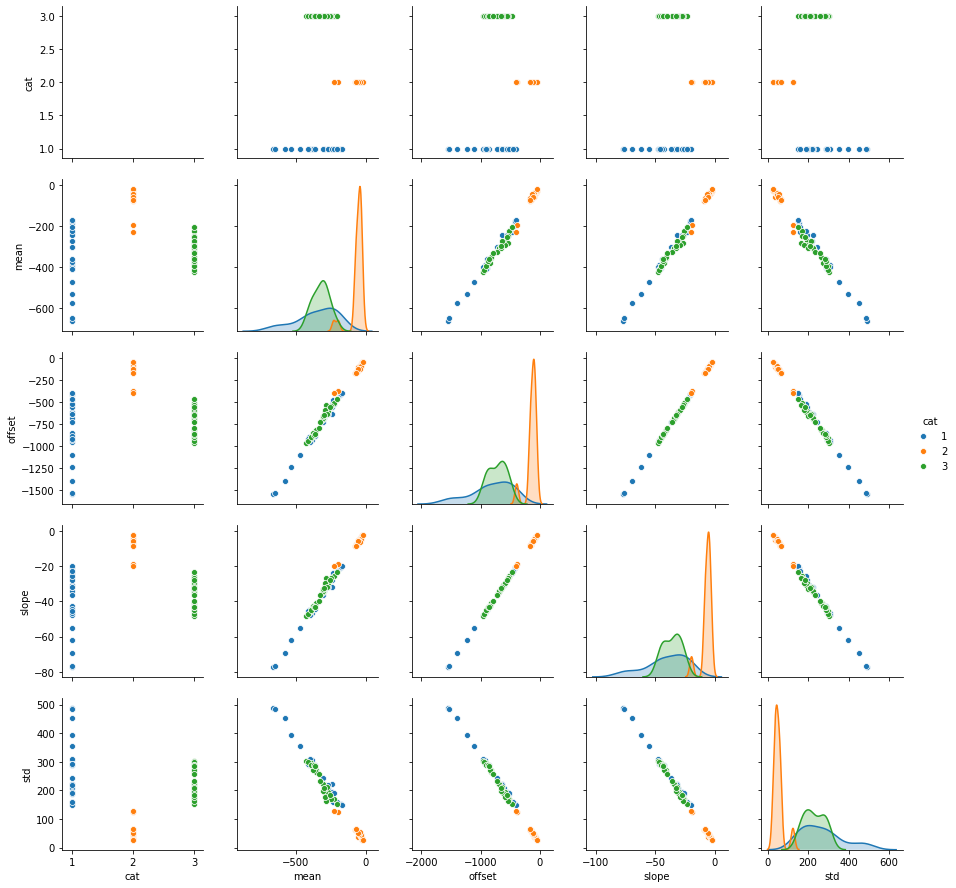

In [8]:
import seaborn as sns
g = sns.pairplot(total, hue="cat")


In [4]:
from patterns.python.config import *
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt


def generate_pattern(rainfall, m):  # rainfall in mm
    
    import numpy as np
    NX=m
    NY=m
    """
    Run the code to converge on a vegetation pattern
    """
    print("Generating pattern with rainfall {}mm".format(rainfall))
    # Initialisation
    popP = np.zeros((m, m))
    popW = np.zeros((m, m))
    popO = np.zeros((m, m))
    dP = np.zeros((m, m))
    dO = np.zeros((m, m))
    dW = np.zeros((m, m))
    NetP = np.zeros((m, m))
    NetW = np.zeros((m, m))
    NetO = np.zeros((m, m))

    # Boundary conditions
    FYP = np.zeros((NY + 1, NX)) # bound.con.no flow in / outo Y - direction
    FXP = np.zeros((NY, NX + 1)) # bound.con.no flow in / out to X - direction
    FYW = np.zeros((NY + 1, NX)) # bound.con.no flow in / out to Y - direction
    FXW = np.zeros((NY, NX + 1)) # bound.con.no flow in / out to X - direction
    FYO = np.zeros((NY + 1, NX)) # bound.con.no flow in / out to Y - direction
    FXO = np.zeros((NY, NX + 1)) # bound.con.no flow in / out to X - direction

    # Initial state
    for i in range(1,m):
        for j in range(1,m):
            if random.random() > frac:
                popO[i, j] = rainfall / (alpha * W0)
                popW[i, j] = rainfall / rw # Homogeneous equilibrium soil water in absence of plants
                popP[i, j] = 90 # Initial plant biomass
            else:
                popO[i, j] = rainfall / (alpha * W0) # Homogeneous equilibrium surface water in absenceof plants
                popW[i, j] = rainfall / rw # Homogeneous equilibriums oil water in absence of plants
                popP[i, j] = 0 # Initial plant biomass

    # Timesteps
    dT = 1  # timestep
    Time = 1  # begin time
    EndTime = 10000  # end time
    PlotStep = 10  # (d)
    PlotTime = PlotStep  #(d)
    #  Timesteps

    snapshots = []
    while Time <= EndTime:

        # Reaction
        drO = (rainfall - np.divide(alpha * (popP + k2 * W0), (popP + k2))* popO)
        drW = (alpha * np.divide((popP + k2 * W0),
                                 (popP + k2)) \
               * popO - gmax * np.divide(popW, (popW + k1))* popP - rw * popW)
        drP = (c * gmax * np.divide(popW,(popW + k1)) * popP - (d + beta)* popP)

        # Diffusion
        # calculate Flow in x - direction: Flow = -D * dpopP / dx;
        FXP[0:NY, 1:NX] = -DifP * (popP[:, 1:NX] - popP[:, 0:(NX - 1)]) *DeltaY / DeltaX
        FXW[0:NY, 1:NX] = -DifW * (popW[:, 1:NX] - popW[:, 0:(NX - 1)]) *DeltaY / DeltaX
        FXO[0:NY, 1:NX] = -DifO * (popO[:, 1:NX] - popO[:, 0:(NX - 1)]) *DeltaY / DeltaX

        # calculate Flow in y - direction: Flow = -D * dpopP / dy;
        FYP[1:NY, 0:NX] = -DifP * (popP[1:NY,:] - popP[0:(NY - 1),:]) *DeltaX / DeltaY
        FYW[1:NY, 0:NX] = -DifW * (popW[1:NY,:] - popW[0:(NY - 1),:]) *DeltaX / DeltaY
        FYO[1:NY, 0:NX] = -DifO * (popO[1:NY,:] - popO[0:(NY - 1),:]) *DeltaX / DeltaY

        # calculate netflow
        NetP = (FXP[:, 0:NX] - FXP[:, 1:(NX + 1)]) + (FYP[0:NY,:] - FYP[1:NY + 1,:])
        NetW = (FXW[:, 0:NX] - FXW[:, 1:(NX + 1)]) + (FYW[0:NY,:] - FYW[1:NY + 1,:])
        NetO = (FXO[:, 0:NX] - FXO[:, 1:(NX + 1)]) + (FYO[0:NY,:] - FYO[1:NY + 1,:])
        # NewO(1:NY, 1:NX)=0;
        # Update
        popW = popW + (drW + (NetW / (DeltaX * DeltaY))) * dT
        popO = popO + (drO + (NetO / (DeltaX * DeltaY))) * dT
        popP = popP + (drP + (NetP / (DeltaX * DeltaY))) * dT

        Time = Time + dT

        PlotTime = PlotTime - dT
        axes = plt.gca()

        if PlotTime <= 0:
            snapshots.append(popP)

    print('Done!')
    binary_pattern = make_binary(snapshots[-1])
    return binary_pattern

def make_binary(value_array, threshold=None, sig_val=255):
    """
    if not given a threshold to use,  look at the (max+min)/2 value
    - for anything below, set to zero, for anything above, set to 1
    """
    if not threshold:
        threshold = (value_array.max() + value_array.min()) / 2.
    new_list_x = []
    for row in value_array:
        new_list_y = np.array([sig_val*int(val > threshold) for val in row])
        new_list_x.append(new_list_y)
    return np.array(new_list_x)

def get_metrix_npix(rainfall, npix):
    
    output =  get_metrics(generate_pattern(rainfall,npix))
    output['n_pix'] = npix
    output['rainfall'] = rainfall
    
    return output


In [7]:
import datetime

def generate_pattern_pixels(rainfall):
    
    output_list = []
    for i in range(1,12):
        
        output_list.append(get_metrix_npix(rainfall,i*10))
        
    
    return (pd.DataFrame.from_dict(output_list))
   


Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!
Generating pattern with rainfall 1.11mm
Done!


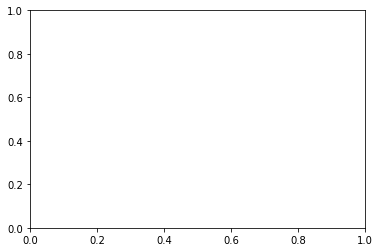

In [8]:
rain_11 = generate_pattern_pixels(1.11)


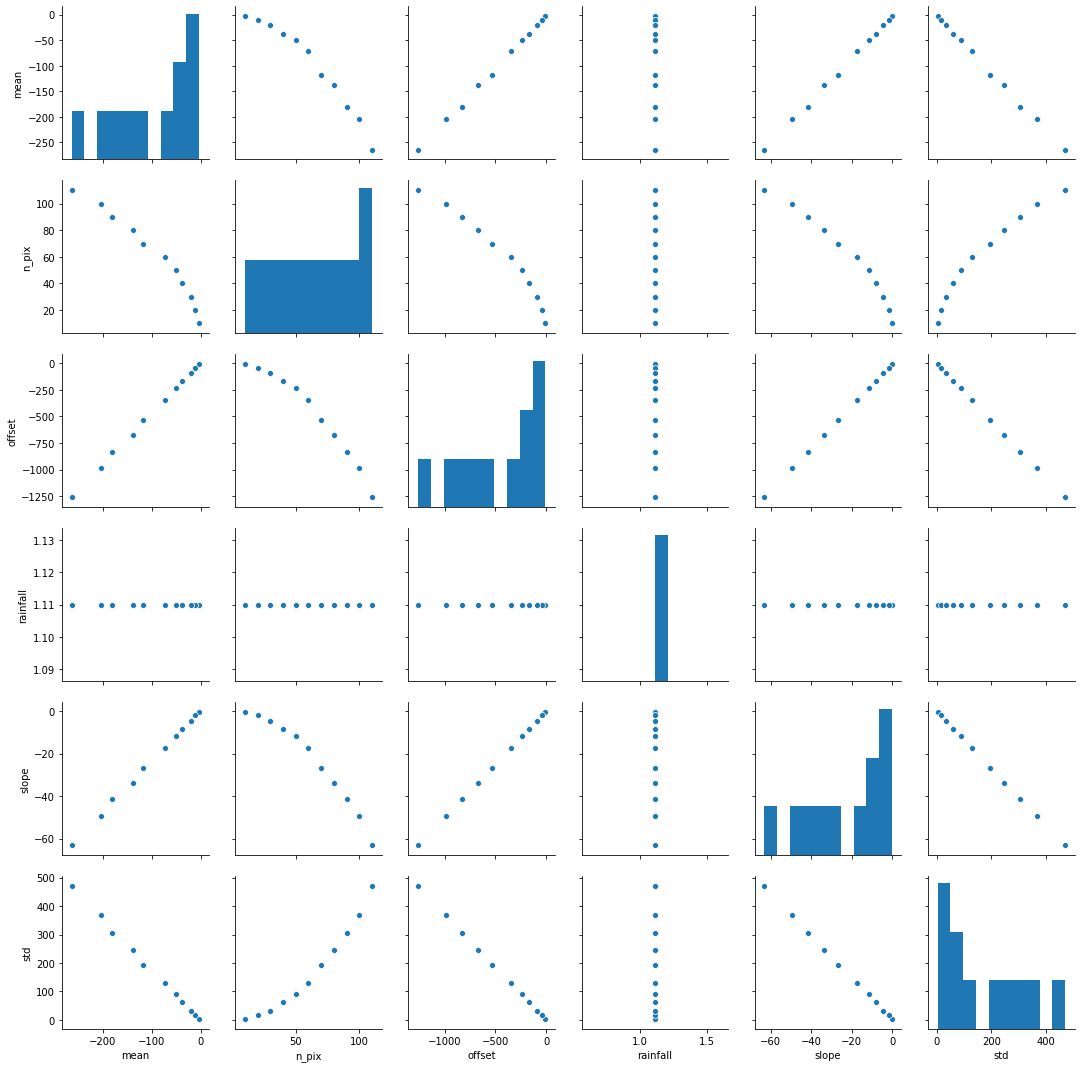

In [13]:
import seaborn as sns
rag = sns.pairplot(rain_11)


Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!
Generating pattern with rainfall 1.15mm
Done!


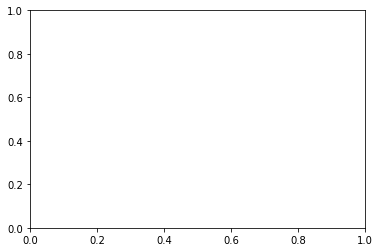

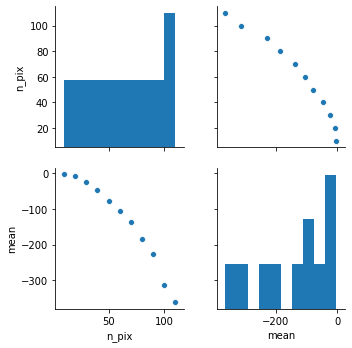

In [11]:
rain_15 = generate_pattern_pixels(1.15)
rag = sns.pairplot(rain_15)


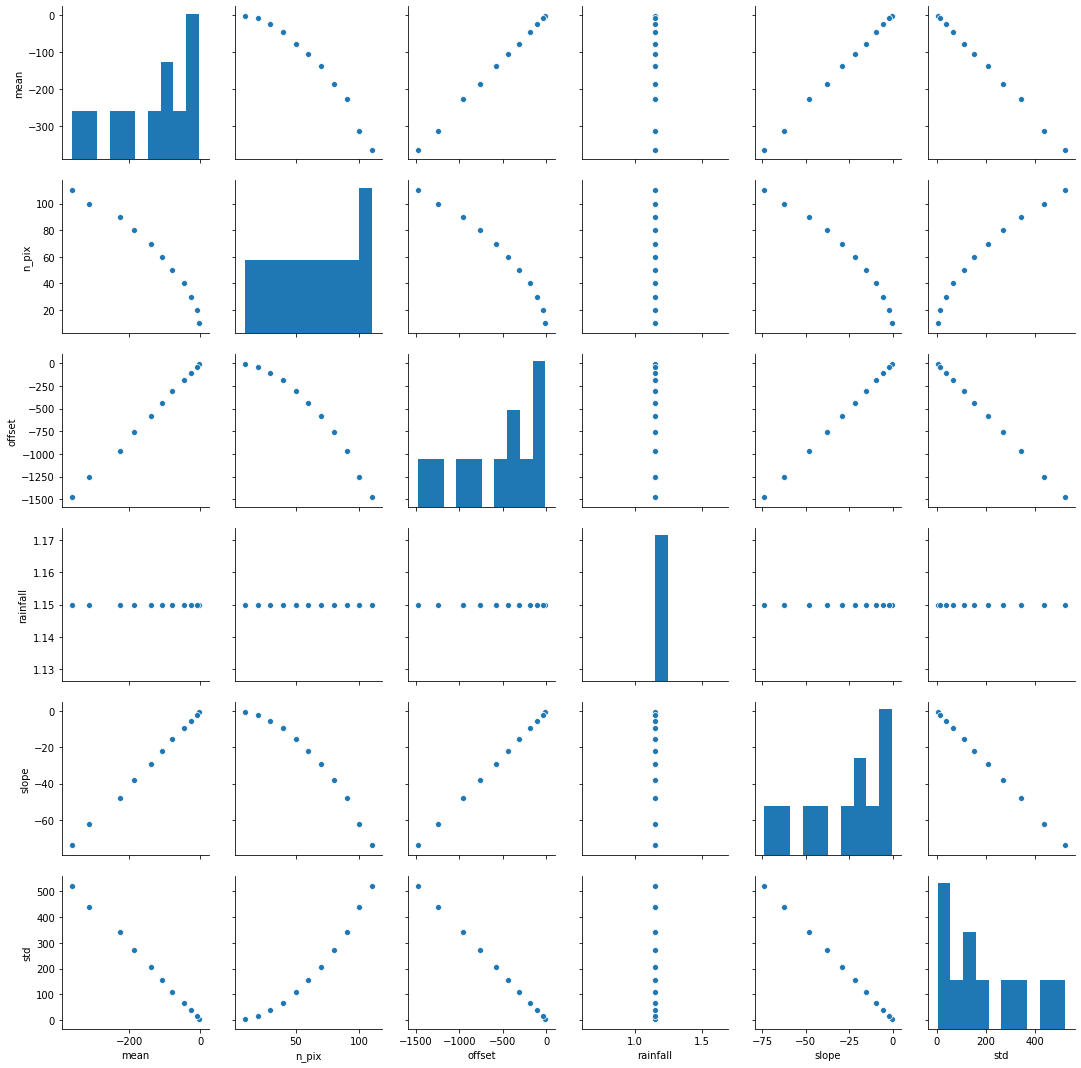

In [14]:
rag = sns.pairplot(rain_15)
